# Predicting Future Stock Prices using Machine Learning Algorithms

In this project I will apply different machine learning algorithms in order to predict whether tomorrow's closing value of a stock will be higher or lower than today's closing value.

In [1]:
#importing all the main libraries we will use in this section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import re
import pickle
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

## Custom Functions

In [ ]:
'''
The function "process_tweets" is used to process the data in order to do a sentiment analysis.
The function returns the dataset with two additional columns: "compound," which contains the sentiment scores, and "sentiment,
"which has three categorical variables: positive, neutral, and negative.

- input:
    df [pd.Dataframe]: the dataframe must include at least 3 columns called: 'Date', 'Stock Name', 'Tweet'.
'''
def preprocess_tweets(df):
  #uncomment if you don't have the package already installed
   # nltk.download('stopwords')
   # nltk.download('punkt')
   # nltk.download('wordnet')
   # nltk.download('omw-1.4')
   # nltk.download('vader_lexicon')

    df.Date = df.Date.dt.tz_localize(None).dt.normalize()
    df['Tweet'] = df['Tweet'].astype(str)
    #step 2: concatenate all tweets of the same day on a unique row
    df = df.groupby(['Stock Name', pd.Grouper(freq='1d', key='Date')]).agg({'Tweet': ' '.join}).reset_index()
    #we "build" the tokenizer
    regexp = RegexpTokenizer('\w+')
    #we apply the tokenizer to the tweets
    df['text_token'] = df['Tweet'].apply(regexp.tokenize)

    #clean the tweets from all the stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    l = [word.capitalize() for word in stopwords]
    my_stopwords = ['https'] + l
    stopwords.extend(my_stopwords)
    df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
    df ["text_string"] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item) > 2]))

    #eliminating the words that appear less than 2 times
    all_words = ' '.join([word for word in df['text_string']])
    tokenized_words = nltk.tokenize.word_tokenize(all_words)
    fdist = FreqDist(tokenized_words)
    df["text_string_fdist"] = df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 2]))


    #lemmatization
    wordnet_lem = WordNetLemmatizer()
    df['text_string_lem'] =  df['text_string_fdist'].apply(wordnet_lem.lemmatize)

    #sentiment analysis
    analyzer = SentimentIntensityAnalyzer()
    df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
    df = pd.concat([df.drop(['polarity'], axis=1),df['polarity'].apply(pd.Series)], axis=1)
    df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0.5 else 'neutral' if 0.5 > x >= 0 else 'negative')

    return df

In [ ]:
'''
df = dataframe from which features and targets are extracted
type [string] = choose btw 'Just_Close' and 'Twitter_sentiment'
split [int] = how many times we randomly extract feature from the dataframe
        remember that we extract the same proportion of data from each stock
        to know the leanght of the feature and target vector moliply split for 20

Options: Just_Close or Twitter_sentiment

#1 'Just_Close': the feature vector will contain only split*10 closing values
#2 'Twitter_sentiment': the feature vector will contain split*10 percent change values and split*10 twitter sentiment scores

'''
def extract_features_targets(df, type, split, random_seed=None):
    if random_seed is not None:
        random.seed(random_seed)
    # Group the DataFrame by 'Stock Name'
    grouped = df.groupby('Stock Name')

    feature_vectors = []
    targets = []
    if type == 'Just_Close':
        for stock in list(grouped.groups.keys()):
            for iterations in range(split):
                # stock_name = random.choice(list(grouped.groups.keys()))

                # Get the indices for the selected stock name
                stock_indices = grouped.groups[stock]

                # Randomly select a start index for the 11-day period
                start_index = random.choice(stock_indices[:-10])

                # Extract the 11-day period
                selected_period = training.iloc[start_index:start_index + 11]

                # Extract the 'Close' and 'compound' values
                close_values = selected_period['Close'].values

                # Create the feature vector with all 10-day periods
                feature_vector = close_values[:-1]

                # Calculate the target value (1 if 'Close' on the 11th day is higher, 0 otherwise)
                target = 1 if close_values[-1] > close_values[-2] else 0

                feature_vectors.append(feature_vector)
                targets.append(target)

    elif type == 'Twitter_sentiment':

        for stock in list(grouped.groups.keys()):
            for iterations in range(split):

                # Get the indices for the selected stock name
                stock_indices = grouped.groups[stock]

                # Randomly select a start index for the 11-day period
                start_index = random.choice(stock_indices[:-10])

                # Extract the 11-day period
                selected_period = df.iloc[start_index:start_index + 11]

                # Extract the 'Close' and 'compound' values
                close_values = selected_period['percentage_change'].values
                compound_values = selected_period['compound'].values

                # Create the feature vector with tuples
                feature_vector = [(close, sentiment) for close, sentiment in zip(close_values[:-1], compound_values[:-1])]

                # Calculate the target value (1 if 'Close' on the 11th day is higher, 0 otherwise)
                target = 1 if close_values[-1] > 0 else 0

                feature_vectors.append(feature_vector)
                targets.append(target)

    return np.array(feature_vectors), np.array(targets)


In [ ]:
'''
the function 'extract_features_pivot' takes as input a pivot table structured as follows: index= date, columns = stock name, and values = close.
It returns a feature vector of non-overlapping (*) 10 day periods and uses the 11th day to build the target vector.

(*) except the last period because we don't have a precise number to extract unique 11days periods so the last one is just the last 11 day available so it will share some data
with the second-last vector.
'''


def extract_features_pivot(pivot_table):
    feature_vectors = []
    target_vectors = []

    for stock_index in pivot_table.columns:
        stock_values = pivot_table[stock_index].values

        # Extract non-overlapping 11-day periods
        for i in range(0, len(stock_values) - 10, 11):
            feature_vector = stock_values[i:i+10]
            target_value = stock_values[i+10]
            target_label = 1 if target_value > stock_values[i+9] else 0

            feature_vectors.append(feature_vector)
            target_vectors.append(target_label)

        # Extract the last 11-day period if not already included
        last_period_start = len(stock_values) - 11
        feature_vector = stock_values[last_period_start:last_period_start+10]
        target_value = stock_values[-1]
        target_label = 1 if target_value > stock_values[-2] else 0

        feature_vectors.append(feature_vector)
        target_vectors.append(target_label)

    feature_vectors = np.array(feature_vectors)
    target_vectors = np.array(target_vectors)

    return feature_vectors, target_vectors


## Building the Dataframes

In [ ]:
training = pd.read_csv('clustering_files/stock_values_train.csv')
#selecting only the column we care about
training = training[['Date', 'Stock Name', 'Close']]

training['percentage_change'] = training.groupby('Stock Name')['Close'].pct_change()

# Print the DataFrame with percentage change
training = training.fillna(0.0)


twitter = pd.read_csv('clustering_files/stock_tweets_train.csv')
twitter = twitter.drop(columns='Unnamed: 0')

training.Date = pd.to_datetime(training.Date)
twitter.Date = pd.to_datetime(twitter.Date)

In [ ]:
cat_tweet = preprocess_tweets(twitter)
training['Date'] = training['Date'].astype(str)
cat_tweet['Date'] = cat_tweet['Date'].astype(str)
cat_tweet.drop(columns = cat_tweet.iloc[:, 2:10], inplace=True)

concat_df = pd.merge(training, cat_tweet, on=['Date', 'Stock Name'], how='left')

groups = concat_df.groupby('Stock Name', group_keys=False)

concat_df['compound'] = groups['compound'].apply(lambda x: x.fillna((x.shift() + x.shift(-1)) / 2))

concat_df['compound'] = groups['compound'].transform(lambda x: x.fillna(x.mean()))

print(concat_df['compound'].isna().sum())

concat_df


0


,Date,Stock Name,Close,percentage_change,compound,sentiment
0,2021-09-30,AMD,102.900002,0.000000,0.95440,positive
1,2021-10-01,AMD,102.618749,-0.002733,0.90290,positive
2,2021-10-04,AMD,101.456120,-0.011330,0.96380,positive
3,2021-10-05,AMD,101.618748,0.001603,0.93370,positive
4,2021-10-06,AMD,102.495418,0.008627,0.95255,NaN
...,...,...,...,...,...,...
3775,2022-06-24,ZS,160.449950,0.045028,0.00000,neutral
3776,2022-06-27,ZS,161.961968,0.009424,0.28595,NaN
3777,2022-06-28,ZS,159.145180,-0.017392,0.57190,positive
3778,2022-06-29,ZS,157.467107,-0.010544,0.45595,NaN


In [ ]:
pivot = pd.pivot(training, index='Date', columns='Stock Name', values='Close')

pivot

Stock Name,AMD,AMZN,BA,BX,COST,ENPH,F,GOOG,INTC,META,MSFT,NFLX,NIO,NOC,PG,PYPL,TSLA,TSM,VZ,ZS
Date,,,,,,,,,,,,,,,,,,,,
2021-09-30,102.900002,164.251999,219.940002,116.339996,449.350006,149.970001,14.160000,133.265503,53.279999,339.390015,281.920013,610.340027,35.630001,360.149994,139.800003,260.209991,258.493347,111.650002,54.009998,262.220001
2021-10-01,102.618749,164.196371,223.727501,115.971249,448.712494,153.338751,14.160000,135.263622,53.642500,341.652512,286.407509,612.096275,35.473751,360.631256,139.662502,262.984993,258.439178,111.593749,54.191249,262.807503
2021-10-04,101.456120,161.794650,223.759385,113.409386,444.338780,149.099592,14.256939,134.499019,53.554490,333.783889,284.725099,607.633878,34.415716,363.202051,139.217345,258.916116,259.495725,110.280610,54.348775,257.222042
2021-10-05,101.618748,161.452441,224.062975,114.053049,445.212498,148.323127,14.272132,135.270151,53.736251,333.405260,286.579378,620.122903,34.164927,366.270963,139.269117,259.483156,259.817844,109.811581,54.422867,257.809339
2021-10-06,102.495418,162.167246,224.465053,113.973657,447.002704,150.603173,14.206148,136.173973,53.841971,333.507079,289.411876,628.353764,33.945926,371.063227,140.102256,261.468254,260.294428,109.607042,54.469333,260.602825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,84.918345,112.396722,137.552647,95.112174,472.612724,195.662709,11.731471,114.307803,37.952229,163.625922,259.744565,183.274268,22.923327,459.528521,140.972566,75.103074,237.702735,85.463265,50.951882,160.449950
2022-06-27,85.415009,112.726034,138.019588,96.215306,476.267634,199.865625,11.854883,115.233681,38.223338,165.971556,261.802745,185.620560,22.933996,462.445116,141.883539,75.437846,240.589640,85.621959,50.955129,161.961968
2022-06-28,83.561005,110.595621,138.291752,95.665182,473.204575,196.179373,11.836930,114.168810,38.046002,163.854930,259.673651,183.212339,22.704398,463.335075,141.498123,73.990707,237.419116,85.109174,50.757077,159.145180



# Training The Models

In [ ]:
# !pip install xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
'''
The function "fit_and_print" is used to plot a confusion matrix and print a classification report of the model we have trained

- input:
    pipeline [pipeline/model] is the model or pipeline we used in our gridsearch cross validation
    name [string] is the title of the plot
'''

def fit_and_print(pipeline, name):

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = metrics.f1_score(y_test, y_pred, average='macro')

    print(metrics.classification_report(y_test, y_pred, digits=3))

    ConfusionMatrixDisplay.from_predictions(y_test,
                                            y_pred,
                                            cmap=plt.cm.Purples)

    plt.tight_layout()
    plt.title(name)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show;

I have considered three possible scenarios to select my feature vectors:
1. Closing values, randomly selecting 10days periods but equally proportionate between the 20 stocks for n split times;
2. Percentage change and tweet sentiment score, taken randomly as point 1 for n split times;
3. Closing values, taken in subsequent non-overlapping periods from each of the 20 stock. In this way we are sure to take every value available just one time.

While point 1 and 2 allow us to create feature vectors of the size I want, point 3 have a fixed size setted by the training dataset. When I choose a high split number, Point 3 actually doesn't perform as well as the other two alternatives. So, I didn't developed it further.

Using additional splits has the drawback of increasing the likelihood that the training and testing data will be similar, which increases the danger of overfitting. The results found might lead you to believe that the tested ensable models are overfitting because they achieved almost perfect scores (close to 100%).
However, I evaluate my model by testing the models with never seen before data and the the results were still outstanding.

### Model Trained
We decided to build 6 models:
1. Random Forest Classifier
2. Gradient Boosting Classifier
3. XGBoost Classifier
4. Logistic Regression
5. Support Vector Machine
6. 3 Naïve Bayes Classifiers: Multinomial, Bernulli, Gaussian

To train and evaluate the different models I implemented pipelines for each one of them. The pipeline included the scaling and the fitting of the model. I applied gridsearch cross-validation to the pipeloine in order to try to find the best hyperparameters in order to improve the accuracy of the models.


## Basic Model: Closing Values
Basic models will use as feature vector only closing values (Scenario 1)

In [ ]:

#1 'Just_Close'
feature_vectors, targets = extract_features_targets(training, 'Just_Close', split=1000, random_seed=1)

print(feature_vectors.shape,targets.shape)

(20000, 10) (20000,)


### 1. Random Forest Classifier (Basic)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 74
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 385
n_resources: 74
Fitting 5 folds for each of 385 candidates, totalling 1925 fits
----------
iter: 1
n_candidates: 129
n_resources: 222
Fitting 5 folds for each of 129 candidates, totalling 645 fits
----------
iter: 2
n_candidates: 43
n_resources: 666
Fitting 5 folds for each of 43 candidates, totalling 215 fits
----------
iter: 3
n_candidates: 15
n_resources: 1998
Fitting 5 folds for each of 15 candidates, totalling 75 fits
----------
iter: 4
n_candidates: 5
n_resources: 5994
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'classifier': RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       n_estimators=1500, random_state=0), 'classifier__bootstrap': True, 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_featur

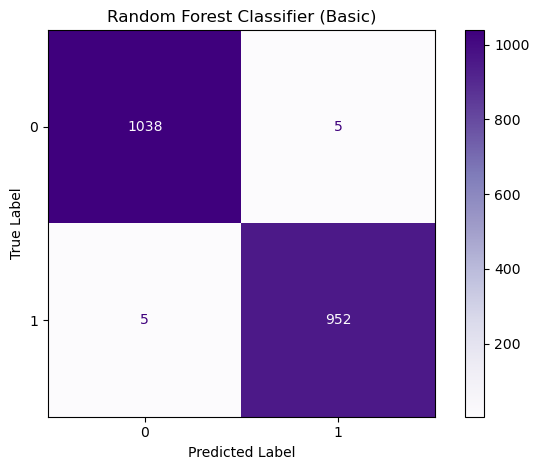

In [ ]:
#Building the pipeline for the random forest classifier
pipe_rf = Pipeline([("preprocessing", None), ("classifier", RandomForestClassifier(n_estimators=1000, random_state=0))])

param_grid_rf = [{'classifier': [RandomForestClassifier(random_state=0)],
                 'preprocessing': [None],
                 'classifier__n_estimators':[500, 1000, 1500],
                 'classifier__max_depth': [2,5,10, None],
                 'classifier__criterion': ['gini', 'entropy'],  # Split quality measure
                 'classifier__min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
                 'classifier__max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
                 'classifier__bootstrap': [True, False]}, # Whether bootstrap samples are used when building trees

                 {'classifier': [RandomForestClassifier(n_estimators=1000, random_state=0)],
                 'preprocessing': [None]}]



#performing the gridsearch cross validation to find the best model

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_rf, param_grid_rf, cv=kf, n_jobs=-1, verbose=1)


grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_rf = grid_search.best_estimator_
pipe_rf.fit(feature_vectors, targets)

fit_and_print(pipe_rf, 'Random Forest Classifier (Basic)')

### 2. Gradient Boosting Classifier (Basic)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 74
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 500
n_resources: 74
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
----------
iter: 1
n_candidates: 167
n_resources: 222
Fitting 5 folds for each of 167 candidates, totalling 835 fits
----------
iter: 2
n_candidates: 56
n_resources: 666
Fitting 5 folds for each of 56 candidates, totalling 280 fits
----------
iter: 3
n_candidates: 19
n_resources: 1998
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 4
n_candidates: 7
n_resources: 5994
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'classifier': GradientBoostingClassifier(learning_rate=0.05, max_depth=5, n_estimators=1000,
                           random_state=0), 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'preprocessing': PowerTr

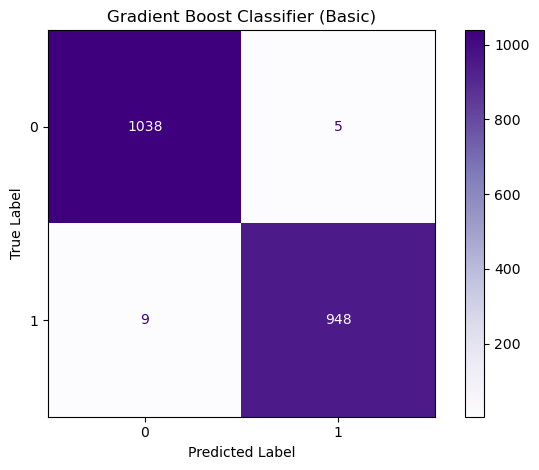

In [ ]:
#Building the pipeline for the random forest classifier
pipe_gb = Pipeline([("preprocessing", StandardScaler()), ("classifier", GradientBoostingClassifier(random_state=0))])

# parameters dictionary for the grid search

param_grid_gb = {'classifier': [GradientBoostingClassifier(random_state=0)],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
                 'classifier__n_estimators':[100, 250, 500,1000],
                 'classifier__max_depth': [1, 2, 3, 4, 5],
                 'classifier__learning_rate': [0.1, 0.05, 0.01 ,0.001, 0.0001],
                 }

#performing the gridsearch cross validation to find the best model

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = HalvingGridSearchCV(pipe_gb, param_grid_gb, cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_gb = grid_search.best_estimator_
pipe_gb.fit(feature_vectors, targets)

fit_and_print(pipe_gb, 'Gradient Boost Classifier (Basic)')

### 3. XGBoost Classifier (Basic)

n_iterations: 7
n_required_iterations: 9
n_possible_iterations: 7
min_resources_: 20
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 17280
n_resources: 20
Fitting 5 folds for each of 17280 candidates, totalling 86400 fits
----------
iter: 1
n_candidates: 5760
n_resources: 60
Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
----------
iter: 2
n_candidates: 1920
n_resources: 180
Fitting 5 folds for each of 1920 candidates, totalling 9600 fits
----------
iter: 3
n_candidates: 640
n_resources: 540
Fitting 5 folds for each of 640 candidates, totalling 3200 fits
----------
iter: 4
n_candidates: 214
n_resources: 1620
Fitting 5 folds for each of 214 candidates, totalling 1070 fits
----------
iter: 5
n_candidates: 72
n_resources: 4860
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------
iter: 6
n_candidates: 24
n_resources: 14580
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'cl

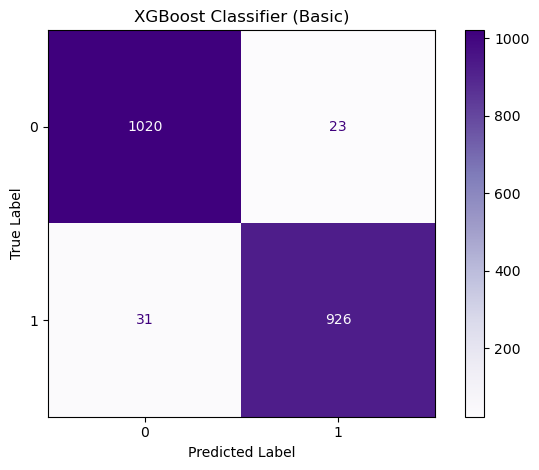

In [ ]:
#Building the pipeline for the random forest classifier
pipe_xgb = Pipeline([("preprocessing", StandardScaler()), ("classifier", XGBClassifier(random_state=0))])

# parameters dictionary for the grid search

param_grid_xgb = {'classifier': [XGBClassifier(random_state=0)],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer(), None],
                 'classifier__n_estimators':[100, 250, 500,1000],
                 'classifier__max_depth': [1, 2, 3, 5],
                 'classifier__learning_rate': [0.1, 0.05, 0.01 ,0.001, 0.0001],
                 'classifier__subsample': [0.8, 0.9, 1.0],
                 'classifier__reg_lambda':[0.1, 1.0, 10.0],
                 'classifier__reg_alpha':[0.0,0.001, 0.1, 1.0]
                 }

#performing the gridsearch cross validation to find the best model

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = HalvingGridSearchCV(pipe_xgb, param_grid_xgb, cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_xgb = grid_search.best_estimator_
pipe_xgb.fit(feature_vectors, targets)

#confusion matrix and classification report
fit_and_print(pipe_xgb, 'XGBoost Classifier (Basic)')

### 4. Logistic Regression (Basic)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 74
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 550
n_resources: 74
Fitting 5 folds for each of 550 candidates, totalling 2750 fits
----------
iter: 1
n_candidates: 184
n_resources: 222
Fitting 5 folds for each of 184 candidates, totalling 920 fits
----------
iter: 2
n_candidates: 62
n_resources: 666
Fitting 5 folds for each of 62 candidates, totalling 310 fits
----------
iter: 3
n_candidates: 21
n_resources: 1998
Fitting 5 folds for each of 21 candidates, totalling 105 fits
----------
iter: 4
n_candidates: 7
n_resources: 5994
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'classifier': LogisticRegression(C=1000, max_iter=21000, random_state=0, solver='newton-cg'), 'classifier__C': 1000, 'classifier__penalty': 'l2', 'preprocessing': PowerTransformer()}
Best cross-validation score:0.72
Best estimator:
Pipeline(steps=[('preproc

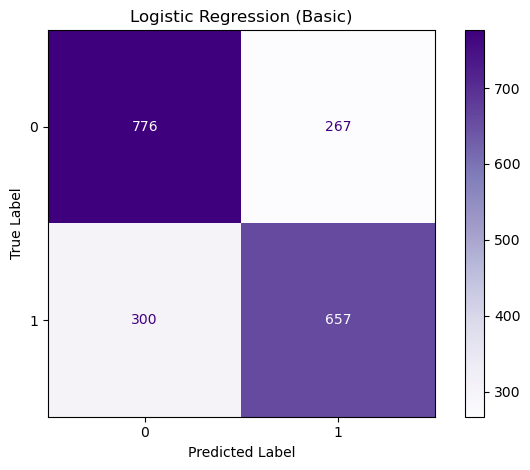

In [ ]:
#Building the pipeline for the random forest classifier
max_iter = len(feature_vectors)+1000
pipe_logit = Pipeline([("preprocessing", StandardScaler()), ("classifier", LogisticRegression(random_state=0))])

# parameters dictionary for the grid search
param_grid_logit = [
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='liblinear', random_state=0)],
        'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l1', 'l2'],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=0)],
        'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': [None, 'l2'],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='saga', random_state=0)],
        'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(), MaxAbsScaler()],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l2','l1'],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='newton-cg', random_state=0)],
        'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l2', None],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='sag', random_state=0)],
        'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l2', None],
    }
]


X_train, X_test, y_train, y_test = train_test_split(feature_vectors, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_logit, param_grid_logit, cv=kf, n_jobs=-1, verbose=2, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_logit = grid_search.best_estimator_
pipe_logit.fit(feature_vectors, targets)

#confusion matrix and classification report
fit_and_print(pipe_logit, 'Logistic Regression (Basic)')

### 5. Support Vector Machine (Basic)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 24
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 960
n_resources: 24
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
----------
iter: 1
n_candidates: 320
n_resources: 72
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
----------
iter: 2
n_candidates: 107
n_resources: 216
Fitting 5 folds for each of 107 candidates, totalling 535 fits
----------
iter: 3
n_candidates: 36
n_resources: 648
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 4
n_candidates: 12
n_resources: 1944
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 5
n_candidates: 4
n_resources: 5832
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 6
n_candidates: 2
n_resources: 17496
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'classifier': SVC(C=10, gam

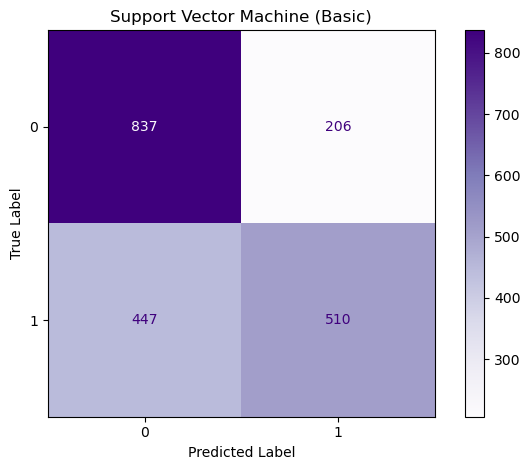

In [ ]:
#Building the pipeline for the random forest classifier
pipe_svm = Pipeline([("preprocessing", StandardScaler()),("classifier", SVC(kernel='linear', random_state=0))])

# parameters dictionary for the grid search
param_grid_svm =[{'classifier': [SVC(kernel = 'linear',random_state=0)],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
                 'classifier__C': [0.1, 1, 5, 10],
                 'classifier__gamma': [0.0001, 0.0005, 0.001, 0.005],
                 'classifier__class_weight':[None, 'balanced']
                 },
                 {'classifier': [SVC(kernel = 'rbf',random_state=0)],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
                 'classifier__C': [0.1, 1, 5, 10],
                 'classifier__gamma': [0.0001, 0.001, 'scale', 'auto', 1],
                 'classifier__class_weight':[None, 'balanced']
                 },
                 {'classifier': [SVC(kernel = 'poly',random_state=0)],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
                 'classifier__C': [0.1, 1, 5, 10],
                 'classifier__gamma': [0.0001, 0.001, 'scale', 'auto', 1],
                 'classifier__class_weight':[None, 'balanced'],
                 'classifier__degree':[2,3,4]
                 }]

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_svm, param_grid_svm, cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset
pipe_svm = grid_search.best_estimator_
pipe_svm.fit(feature_vectors, targets)

#confusion matrix and classification report
fit_and_print(pipe_svm, 'Support Vector Machine (Basic)')


### 6. Naïve Bayes Classifiers: MultinomialNB, GaussianNB, BernoulliNB (Basic)

Best parameters: {'classifier': MultinomialNB(alpha=100.0, fit_prior=False), 'classifier__alpha': 100.0, 'classifier__fit_prior': False, 'preprocessing': MinMaxScaler()}
Best cross-validation score:0.59
Best estimator:
Pipeline(steps=[('preprocessing', MinMaxScaler()),
                ('classifier', MultinomialNB(alpha=100.0, fit_prior=False))])
Test-set score: 0.58
-----------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.613     0.542     0.575      1043
           1      0.557     0.628     0.590       957

    accuracy                          0.583      2000
   macro avg      0.585     0.585     0.583      2000
weighted avg      0.586     0.583     0.583      2000



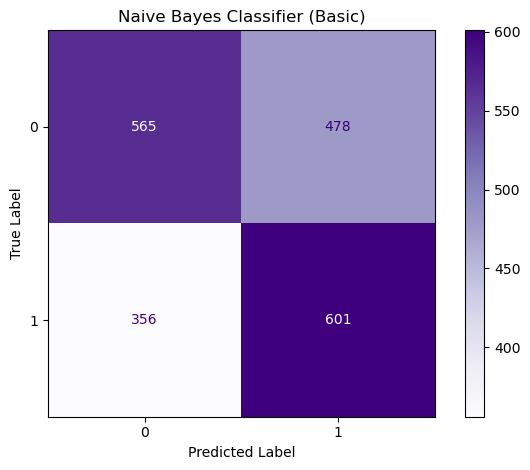

In [ ]:
#Building the pipeline for the random forest classifier
pipe_nb = Pipeline([("preprocessing", StandardScaler()), ("classifier", GaussianNB())])

# parameters dictionary for the grid search
param_grid_nb =[{'classifier': [MultinomialNB()],
                'preprocessing': [MinMaxScaler()],
                'classifier__alpha': [0.00001, 0.001, 0.1, 0.5, 1.0, 10.0, 100.0],
                'classifier__fit_prior': [True, False]},
                {'classifier': [GaussianNB()],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
                 'classifier__var_smoothing': [1e-09, 1e-08, 1e-07]},
                {'classifier':[BernoulliNB()],
                 'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()],
                 'classifier__alpha': [0.00001, 0.001, 0.1, 0.5, 1.0, 10.0, 100.0],
                 'classifier__binarize': [0.0, 0.5, 1.0],
                 'classifier__fit_prior': [True, False]},
                {'classifier': [MultinomialNB()],
                'preprocessing': [MinMaxScaler()]},
                {'classifier': [GaussianNB()],
                'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()]},
                {'classifier': [BernoulliNB()],
                'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), PowerTransformer()]}
                ]

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_nb, param_grid_nb, cv=kf, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_nb = grid_search.best_estimator_
pipe_nb.fit(feature_vectors, targets)

#confusion matrix and classification report
fit_and_print(pipe_nb, 'Naïve Bayes Classifier (Basic)')


Looking at the training results, we can affirm that the ensable models (Random Forest Classifier, XGBoost Classifier, Gradient Boost Classifier) give better results.

## Enhanced Models with Twitter Sentiment Score

In the following section the models will be trained with both percentage changes and twitter sentiment scores (Senario 2).

In [ ]:
#2 'Twitter_sentiment'
feature_vectors, targets = extract_features_targets(concat_df, 'Twitter_sentiment', split=1000, random_seed = 2)

print(feature_vectors.shape,targets.shape)

(20000, 10, 2) (20000,)


### 1. Random Forest Classifier (Enhanced)

In [ ]:
#reshaping the vector in 2D so it can be scaled
feature_vectors_re = feature_vectors.reshape(feature_vectors.shape[0], feature_vectors.shape[1] * feature_vectors.shape[2])

#Building the pipeline for the Random Forest Classifier
pipe_rf = Pipeline([("preprocessing", None), ("classifier", RandomForestClassifier(n_estimators=1000, random_state=0))])

param_grid_rf = [{'classifier': [RandomForestClassifier(random_state=0)],
                 'preprocessing': [None],
                 'classifier__n_estimators':[500, 1000, 1500],
                 'classifier__max_depth': [2,5,10, None],
                 'classifier__criterion': ['gini', 'entropy'],  # Split quality measure
                 'classifier__min_samples_leaf': [1, 2, 4, 6],  # Minimum number of samples required to be at a leaf node
                 'classifier__max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
                 'classifier__bootstrap': [True, False]}, # Whether bootstrap samples are used when building trees

                 {'classifier': [RandomForestClassifier(n_estimators=1000, random_state=0)],
                 'preprocessing': [None]}]



#performing the gridsearch cross validation to find the best model

X_train, X_test, y_train, y_test = train_test_split(feature_vectors_re, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_rf, param_grid_rf, cv=kf, n_jobs=-1, verbose=1)


grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

#training the best model on the entire dataset

pipe_rf = grid_search.best_estimator_
pipe_rf.fit(feature_vectors_re, targets)

n_iterations: 5
n_required_iterations: 6
n_possible_iterations: 5
min_resources_: 74
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 257
n_resources: 74
Fitting 5 folds for each of 257 candidates, totalling 1285 fits
----------
iter: 1
n_candidates: 86
n_resources: 222
Fitting 5 folds for each of 86 candidates, totalling 430 fits
----------
iter: 2
n_candidates: 29
n_resources: 666
Fitting 5 folds for each of 29 candidates, totalling 145 fits
----------
iter: 3
n_candidates: 10
n_resources: 1998
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 4
n_candidates: 4
n_resources: 5994
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'classifier': RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=1000, random_state=0), 'classifier__bootstrap': True, 'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_feature

Pipeline(steps=[('preprocessing', None),
                ('classifier',
                 RandomForestClassifier(criterion='entropy',
                                        max_features='log2', n_estimators=1000,
                                        random_state=0))])

              precision    recall  f1-score   support

           0      0.997     0.997     0.997      1053
           1      0.997     0.997     0.997       947

    accuracy                          0.997      2000
   macro avg      0.997     0.997     0.997      2000
weighted avg      0.997     0.997     0.997      2000



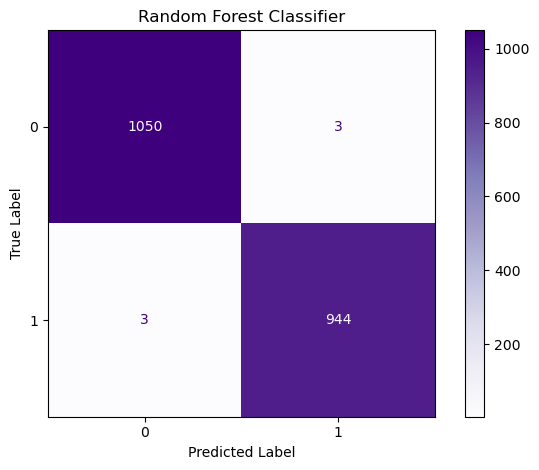

In [ ]:
fit_and_print(pipe_rf, 'Random Forest Classifier (Enhanced)')

### 2. Gradient Boosting Classifier (Enhanced)

In [ ]:
#reshaping the vector in 2D so it can be scaled
feature_vectors_re = feature_vectors.reshape(feature_vectors.shape[0], feature_vectors.shape[1] * feature_vectors.shape[2])

#Building the pipeline for the random forest classifier
pipe_gb = Pipeline([("preprocessing", None), ("classifier", GradientBoostingClassifier(random_state=0))])

# parameters dictionary for the grid search

param_grid_gb = {'classifier': [GradientBoostingClassifier(random_state=0)],
                 'preprocessing': [None],
                 'classifier__n_estimators':[100, 250, 500,1000],
                 'classifier__max_depth': [1, 2, 3, 4, 5],
                 'classifier__learning_rate': [0.1, 0.05, 0.01 ,0.001, 0.0001],
                 }

#performing the gridsearch cross validation to find the best model

X_train, X_test, y_train, y_test = train_test_split(feature_vectors_re, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = HalvingGridSearchCV(pipe_gb, param_grid_gb, cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_gb = grid_search.best_estimator_
pipe_gb.fit(feature_vectors_re, targets)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 222
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 100
n_resources: 222
Fitting 5 folds for each of 100 candidates, totalling 500 fits
----------
iter: 1
n_candidates: 34
n_resources: 666
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 12
n_resources: 1998
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 5994
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 17982
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'classifier': GradientBoostingClassifier(max_depth=5, n_estimators=1000, random_state=0), 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 1000, 'preprocessing': None}
Best cross-validation score:1.00
Best estimator:
Pi

Pipeline(steps=[('preprocessing', None),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=1000,
                                            random_state=0))])

              precision    recall  f1-score   support

           0      0.996     0.996     0.996      1053
           1      0.996     0.996     0.996       947

    accuracy                          0.996      2000
   macro avg      0.996     0.996     0.996      2000
weighted avg      0.996     0.996     0.996      2000



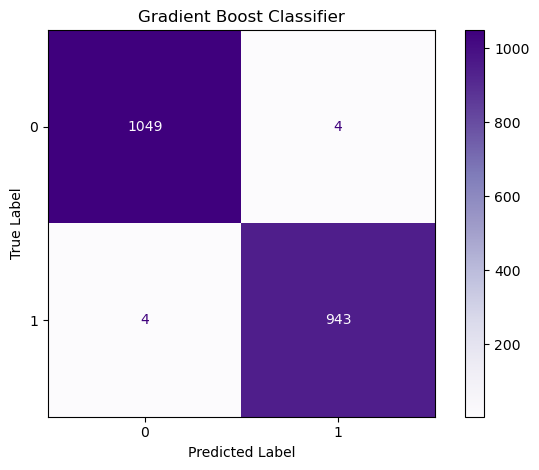

In [ ]:
fit_and_print(pipe_gb, 'Gradient Boost Classifier (Enhanced)')

### 3. XGBoost Classifier (Enhanced)

In [ ]:
#reshaping the vector in 2D so it can be scaled
feature_vectors_re = feature_vectors.reshape(feature_vectors.shape[0], feature_vectors.shape[1] * feature_vectors.shape[2])


#Building the pipeline for the random forest classifier
pipe_xgb = Pipeline([("preprocessing", None), ("classifier", XGBClassifier(random_state=0))])

# parameters dictionary for the grid search

param_grid_xgb = {'classifier': [XGBClassifier(random_state=0)],
                 'preprocessing': [None],
                 'classifier__n_estimators':[100, 250, 500,1000],
                 'classifier__max_depth': [1, 2, 3, 5],
                 'classifier__learning_rate': [0.1, 0.05, 0.01 ,0.001, 0.0001],
                 'classifier__subsample': [0.8, 0.9, 1.0],
                 'classifier__reg_lambda':[0.1, 1.0, 10.0],
                 'classifier__reg_alpha':[0.0,0.001, 0.1, 1.0]
                 }

#performing the gridsearch cross validation to find the best model

X_train, X_test, y_train, y_test = train_test_split(feature_vectors_re, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

grid_search = HalvingGridSearchCV(pipe_xgb, param_grid_xgb, cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_xgb = grid_search.best_estimator_
pipe_xgb.fit(feature_vectors_re, targets)

n_iterations: 7
n_required_iterations: 8
n_possible_iterations: 7
min_resources_: 20
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 2880
n_resources: 20
Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
----------
iter: 1
n_candidates: 960
n_resources: 60
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
----------
iter: 2
n_candidates: 320
n_resources: 180
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
----------
iter: 3
n_candidates: 107
n_resources: 540
Fitting 5 folds for each of 107 candidates, totalling 535 fits
----------
iter: 4
n_candidates: 36
n_resources: 1620
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 5
n_candidates: 12
n_resources: 4860
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 6
n_candidates: 4
n_resources: 14580
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'classifier': XGBC

Pipeline(steps=[('preprocessing', None),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=0, ...))])

              precision    recall  f1-score   support

           0      0.998     0.999     0.999      1053
           1      0.999     0.998     0.998       947

    accuracy                          0.999      2000
   macro avg      0.999     0.998     0.998      2000
weighted avg      0.999     0.999     0.998      2000



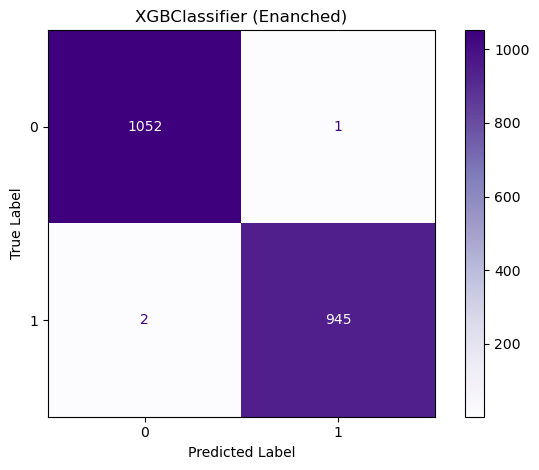

In [ ]:
fit_and_print(pipe_xgb, 'XGBClassifier (Enhanced)')

### 4. Logistic Regression (Enhanced)

In [ ]:
#reshaping the vector in 2D so it can be scaled
feature_vectors_re = feature_vectors.reshape(feature_vectors.shape[0], feature_vectors.shape[1] * feature_vectors.shape[2])

#Building the pipeline for the random forest classifier
max_iter = len(feature_vectors_re)+1000
pipe_logit = Pipeline([("preprocessing", None), ("classifier", LogisticRegression(random_state=0))])

# parameters dictionary for the grid search
param_grid_logit = [
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='liblinear', random_state=0)],
        'preprocessing': [None],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l1', 'l2'],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=0)],
        'preprocessing': [None],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': [None, 'l2'],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='saga', random_state=0)],
        'preprocessing': [None],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l2','l1'],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='newton-cg', random_state=0)],
        'preprocessing': [None],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l2', None],
    },
    {
        'classifier': [LogisticRegression(max_iter=max_iter, solver='sag', random_state=0)],
        'preprocessing': [None],
        'classifier__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500, 1000, 10000],
        'classifier__penalty': ['l2', None],
    }
]


X_train, X_test, y_train, y_test = train_test_split(feature_vectors_re, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_logit, param_grid_logit, cv=kf, n_jobs=-1, verbose=2, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_logit = grid_search.best_estimator_
pipe_logit.fit(feature_vectors_re, targets)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 222
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 110
n_resources: 222
Fitting 5 folds for each of 110 candidates, totalling 550 fits
----------
iter: 1
n_candidates: 37
n_resources: 666
Fitting 5 folds for each of 37 candidates, totalling 185 fits
----------
iter: 2
n_candidates: 13
n_resources: 1998
Fitting 5 folds for each of 13 candidates, totalling 65 fits
----------
iter: 3
n_candidates: 5
n_resources: 5994
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 4
n_candidates: 2
n_resources: 17982
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'classifier': LogisticRegression(C=100, max_iter=21000, penalty='l1', random_state=0,
                   solver='liblinear'), 'classifier__C': 100, 'classifier__penalty': 'l1', 'preprocessing': None}
Best cross-validation score:0.72
Best estimator:
Pipeline(st

Pipeline(steps=[('preprocessing', None),
                ('classifier',
                 LogisticRegression(C=100, max_iter=21000, penalty='l1',
                                    random_state=0, solver='liblinear'))])

              precision    recall  f1-score   support

           0      0.744     0.707     0.725      1053
           1      0.691     0.730     0.710       947

    accuracy                          0.718      2000
   macro avg      0.718     0.718     0.717      2000
weighted avg      0.719     0.718     0.718      2000



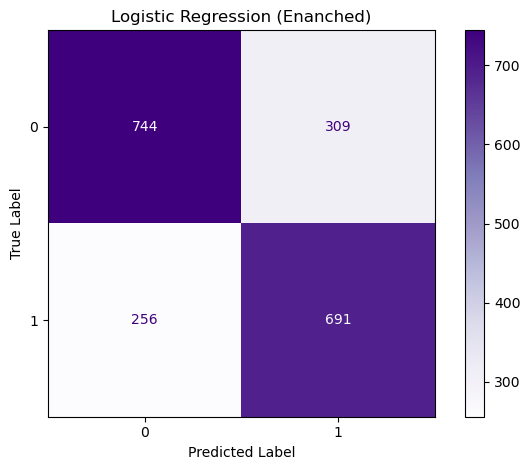

In [ ]:
fit_and_print(pipe_logit, 'Logistic Regression (Enhanced)')

### 5. Support Vector Machine (Enhanced)

In [ ]:
#reshaping the vector in 2D so it can be scaled
feature_vectors_re = feature_vectors.reshape(feature_vectors.shape[0], feature_vectors.shape[1] * feature_vectors.shape[2])


#Building the pipeline for the random forest classifier
pipe_svm = Pipeline([("preprocessing", None),("classifier", SVC(random_state=0))])

# parameters dictionary for the grid search
param_grid_svm =[{'classifier': [SVC(kernel = 'linear', random_state=0)],
                 'preprocessing': [None],
                 'classifier__C': [0.1, 1, 5, 10],
                 'classifier__gamma': [0.0001, 0.0005, 0.001, 0.005],
                 'classifier__class_weight':[None, 'balanced']
                 },
                 {'classifier': [SVC(kernel = 'rbf', random_state=0)],
                 'preprocessing': [None],
                 'classifier__C': [0.1, 1, 5, 10],
                 'classifier__gamma': [0.0001, 0.001, 'scale', 'auto', 1],
                 'classifier__class_weight':[None, 'balanced']
                 },
                 {'classifier': [SVC(kernel = 'poly', random_state=0)],
                 'preprocessing': [None],
                 'classifier__C': [0.1, 1, 5, 10],
                 'classifier__gamma': [0.0001, 0.001, 'scale', 'auto', 1],
                 'classifier__class_weight':[None, 'balanced'],
                 'classifier__degree':[2,3,4]
                 }]

X_train, X_test, y_train, y_test = train_test_split(feature_vectors_re, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_svm, param_grid_svm, cv=kf, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset
pipe_svm = grid_search.best_estimator_
pipe_svm.fit(feature_vectors_re, targets)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 222
max_resources_: 18000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 192
n_resources: 222
Fitting 5 folds for each of 192 candidates, totalling 960 fits
----------
iter: 1
n_candidates: 64
n_resources: 666
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 2
n_candidates: 22
n_resources: 1998
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 3
n_candidates: 8
n_resources: 5994
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 4
n_candidates: 3
n_resources: 17982
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'classifier': SVC(C=10, class_weight='balanced', gamma=0.0001, kernel='linear',
    random_state=0), 'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__gamma': 0.0001, 'preprocessing': None}
Best cross-validation score:0.71
Best estimat

Pipeline(steps=[('preprocessing', None),
                ('classifier',
                 SVC(C=10, class_weight='balanced', gamma=0.0001,
                     kernel='linear', random_state=0))])

              precision    recall  f1-score   support

           0      0.740     0.701     0.720      1053
           1      0.686     0.727     0.706       947

    accuracy                          0.713      2000
   macro avg      0.713     0.714     0.713      2000
weighted avg      0.715     0.713     0.713      2000



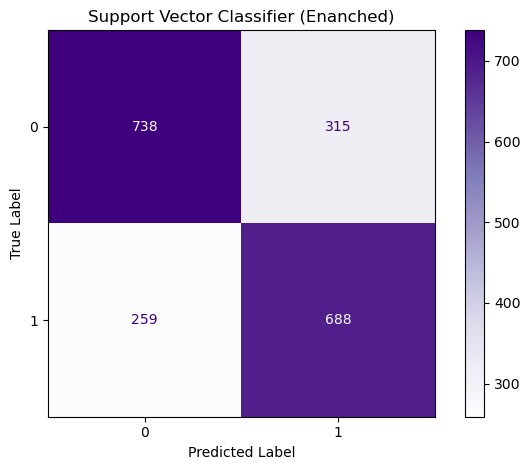

In [ ]:
fit_and_print(pipe_svm, 'Support Vector Classifier (Enhanced)')

### 6. Naïve Bayes Classifiers: MultinomialNB, GaussianNB, BernoulliNB (Enhanced)

In [ ]:
#reshaping the vector in 2D so it can be scaled
feature_vectors_re = feature_vectors.reshape(feature_vectors.shape[0], feature_vectors.shape[1] * feature_vectors.shape[2])


#building the pipeline for the random forest classifier
pipe_nb = Pipeline([("preprocessing", None), ("classifier", GaussianNB())])

#parameters dictionary for the grid search
param_grid_nb =[{'classifier': [MultinomialNB()],
                'preprocessing': [MinMaxScaler()],
                'classifier__alpha': [0.00001, 0.001, 0.1, 0.5, 1.0, 10.0, 100.0],
                'classifier__fit_prior': [True, False]},
                {'classifier': [GaussianNB()],
                 'preprocessing': [None],
                 'classifier__var_smoothing': [1e-09, 1e-08, 1e-07]},
                {'classifier':[BernoulliNB()],
                 'preprocessing': [None],
                 'classifier__alpha': [0.00001, 0.001, 0.1, 0.5, 1.0, 10.0, 100.0],
                 'classifier__binarize': [0.0, 0.5, 1.0],
                 'classifier__fit_prior': [True, False]},
                # {'classifier': [MultinomialNB()],
                # 'preprocessing': [MinMaxScaler()]},
                # {'classifier': [GaussianNB()],
                # 'preprocessing': [None]},
                # {'classifier': [BernoulliNB()],
                # 'preprocessing': [None]}
                ]

X_train, X_test, y_train, y_test = train_test_split(feature_vectors_re, targets, test_size=0.1, random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
grid_search = HalvingGridSearchCV(pipe_nb, param_grid_nb, cv=kf, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters: {}".format(grid_search.best_params_))

print("Best cross-validation score:{:.2f}".format(grid_search.best_score_))

print("Best estimator:\n{}".format(grid_search.best_estimator_))

print("Test-set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print('-----------------------------------------------------------------')

# Training the best model on the entire dataset

pipe_nb = grid_search.best_estimator_
pipe_nb.fit(feature_vectors_re, targets)


Best parameters: {'classifier': BernoulliNB(alpha=0.1), 'classifier__alpha': 0.1, 'classifier__binarize': 0.0, 'classifier__fit_prior': True, 'preprocessing': None}
Best cross-validation score:0.69
Best estimator:
Pipeline(steps=[('preprocessing', None),
                ('classifier', BernoulliNB(alpha=0.1))])
Test-set score: 0.68
-----------------------------------------------------------------


Pipeline(steps=[('preprocessing', None),
                ('classifier', BernoulliNB(alpha=0.1))])

              precision    recall  f1-score   support

           0      0.699     0.696     0.698      1053
           1      0.664     0.667     0.666       947

    accuracy                          0.682      2000
   macro avg      0.682     0.682     0.682      2000
weighted avg      0.683     0.682     0.683      2000



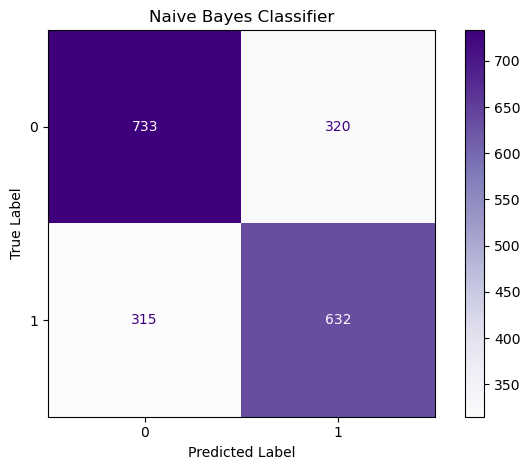

In [ ]:
fit_and_print(pipe_nb, 'Naive Bayes Classifier')

Looking at these new results, we can state that they improved.

# Testing

To actually evaluate the effectiveness of my models I will test the models on never-before-seen data. In the following section I will use a test pickle file, provided by my university professor. The pickle file contains different dataframes of many stocks and thier related tweets. 

(The percentage next to the algorithm name is the score achieved by the model on the test platform)

In [ ]:
'''
The function "extracting_test_vector" is used to extract from each sample in the pickle file a feature vector
with both percentage changes and twitter sentiment score and apply the model to make the prediction. The function will return a list of
true and false values, True if the value predicted is higher than the day before, or False if the value predicted to be lower.

- input:
    sample_test [pickle file]: the file must be a list of tuples each containing in the first position a the percent changes values
                                and in the second position a list of tweets related to the period of the pct_change values.
'''

def extracting_test_vector(sample_test):
    predictions = []
    for values, tweet in sample_test:
        val = pd.DataFrame(values)
        current_column_name = val.columns[0]
        new_column_name = 'pct_change'
        val = val.rename(columns={current_column_name: new_column_name})
        val = val.reset_index()

        tweet = tweet.reset_index()
        tweet.Date = tweet.Date.dt.tz_localize(None).dt.normalize()
        tweet = tweet[['Date', 'Stock Name', 'Tweet']]
        #sentimentiment analysis
        sentiment = preprocess_tweets(tweet)
        sentiment = sentiment[['Date', 'compound']]

        df = pd.merge(val, sentiment, on='Date', how='left')
        df = df.fillna(0.0)
        features = [(close, sentiment) for close, sentiment in zip(df['pct_change'].values[-10:], df['compound'].values[-10:])]

        X = np.array(features)

        X_re = X.reshape(X.shape[0] * X.shape[1])
        y_pred = model.predict(X_re.reshape(1,-1))
        predictions.extend(y_pred)

    pred = (np.array(predictions) > 0).tolist()

    return pred

## Random Forest

### Just Closing values (82%)

In [ ]:
with open('test_samples_raw.pkl','rb') as f:
    samples_test = pickle.load(f)

In [ ]:
predictions= []
model = pipe_rf
for values, tweet in samples_test:

    X= values['Close'].values[-10:].reshape(1,-1)

    y_pred = model.predict(X)
    predictions.extend(y_pred)

pred_rand = (np.array(predictions) > 0).tolist()

print(pred_rand)

[True, False, False, False, False, True, True, True, False, False, True, False, True, False, False, True, False, False, True, False, False, False, True, True, True, False, False, True, True, False, True, False, False, False, False, False, False, True, False, False, False, True, True, True, True, True, True, False, False, False, True, False, False, False, True, True, True, False, False, True, True, True, False, False, True, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, False, False, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, False, False, False, False, True, False, True, False, False, False, True, True, False, True, True, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True, False, False, False, True, True, False, True, True, False, True, False,

### With Twitter Sentiment (86.8%)

In [ ]:
#for using twitter sentiment
with open('test_samples (4).pkl', 'rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using also twitter sentiment
model = pipe_rf
pred_rand = extracting_test_vector(samples_test)

print(pred_rand)

[True, False, False, False, False, True, True, True, False, False, True, False, True, False, False, True, True, True, False, True, False, False, False, True, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, True, False, False, False, False, True, True, False, False, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, False, False, False, False, False, False, False, True, True, False, False, False, True, True, True, True, True, False, False, False, True, False, False, False, False, False, True, False, False, True, True, False, True, True, False, True, True, False, False, True, False, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, False, True, False, True, False, False, True, True, False, True, False, True, False, True, False, False, False, False, True, True, False,

## Gradient boost

### Just closing values (83.3%)

In [ ]:
with open('test_samples_raw.pkl','rb') as f:
    samples_test = pickle.load(f)

In [ ]:
predictions= []
model = pipe_gb

for values, tweet in samples_test:
    X= values['Close'].values[-10:].reshape(1,-1)
    y_pred = model.predict(X)
    predictions.extend(y_pred)

pred_grand = (np.array(predictions) > 0).tolist()

print(pred_grand)

[True, False, False, False, False, True, True, True, False, False, True, False, True, False, False, True, False, False, True, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, False, False, True, False, False, True, True, True, True, False, False, True, True, True, False, False, True, True, False, True, False, True, True, False, True, True, True, False, False, False, False, False, False, False, True, True, False, False, False, True, True, True, True, False, False, False, True, True, True, False, False, False, False, True, False, True, True, True, False, True, True, False, True, True, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True, False, False, False, True, True, False, True, True, False, True, True

### With Twitter Sentiment (85.1%)

In [ ]:
#for using twitter sentiment
with open('test_samples (4).pkl', 'rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using also twitter sentiment
model = pipe_gb
pred_grand = extracting_test_vector(samples_test)

print(pred_grand)


[True, False, False, False, False, True, True, True, False, False, True, False, True, False, False, True, True, False, False, True, False, False, False, True, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, True, False, False, False, False, True, True, True, False, True, True, False, True, False, True, True, False, True, False, True, True, False, True, True, True, False, False, False, False, False, False, False, True, True, False, False, False, True, True, True, True, False, False, False, False, True, False, False, False, False, False, False, True, False, True, True, False, True, True, False, True, True, False, False, False, False, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, True, True, False, True, False, False, False, True, False, False, False, False, True, True,

## Xgboost

### Just closing values (81.4%)

In [ ]:
with open('test_samples_raw.pkl','rb') as f:
    samples_test = pickle.load(f)

In [ ]:
predictions= []
model = pipe_xgb
for values, tweet in samples_test:

    X= values['Close'].values[-10:].reshape(1,-1)
    y_pred = model.predict(X)
    predictions.extend(y_pred)

pred_xgb = (np.array(predictions) > 0).tolist()

print(pred_xgb)

[True, False, False, False, False, True, True, True, False, False, True, False, True, False, False, True, True, False, True, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, False, False, True, False, False, True, True, True, True, False, False, False, False, True, False, False, False, True, False, True, False, True, True, False, True, True, True, False, False, False, True, False, False, False, True, True, False, False, False, True, True, True, True, False, False, False, True, True, False, False, False, False, False, False, False, True, True, True, False, True, True, False, True, True, False, False, False, True, False, False, True, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True, False, False, False, True, True, False, True, True, True, True, Tru

### With twitter sentiment (83.9%)

In [ ]:
#for using twitter sentiment
with open('test_samples (4).pkl', 'rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using also twitter sentiment
model = pipe_xgb
pred_xgb = extracting_test_vector(samples_test)

print(pred_xgb)


[True, True, False, False, False, True, True, True, False, False, True, False, True, False, False, True, True, True, True, True, False, False, False, True, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, True, False, False, False, False, True, False, True, False, False, True, False, True, True, True, True, False, True, False, False, True, False, True, True, True, False, False, False, False, False, False, False, True, True, False, False, False, True, True, True, True, True, False, False, False, True, False, False, False, False, True, False, False, False, True, True, False, True, True, False, True, True, False, False, False, False, False, True, True, False, True, False, False, True, False, False, False, False, False, False, False, False, True, False, True, False, False, True, True, False, True, False, False, False, True, False, False, False, False, True, True, Fal

## Logistic Regression


### Just closing values (71.7%)

In [ ]:
#for using closing values
with open('test_samples_raw.pkl','rb') as f:
    samples_test = pickle.load(f)

In [ ]:
# to test with just closing values
predictions= []
model = pipe_logit
for values, tweet in samples_test:

    X= values['Close'].values[-10:].reshape(1,-1)
    y_pred = model.predict(X)
    predictions.extend(y_pred)

pred_logit = (np.array(predictions) > 0).tolist()

print(pred_logit)

[True, True, True, True, True, True, True, True, False, False, True, False, True, False, False, True, True, True, False, True, False, False, False, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, True, False, False, False, False, True, True, True, False, False, False, True, True, False, False, False, False, True, True, False, True, False, True, True, True, True, True, True, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, True, True, True, False, True, False, True, True, False, False, False, False, False, False, False, True, False, False, True, True, True, True, True, True, False, False, True, False, False, True, False, False, False, False, False, True, False, False, True, True, False, False, True, False, False, True, False, False, False, True, False, False, True, True, False, False, False, True, False, True, False, False, False, False, True, True, False, Tr

### With Twitter sentiment (71.5%)

In [ ]:
#for using twitter sentiment
with open('test_samples (4).pkl','rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using also twitter sentiment
model = pipe_logit
pred_logit = extracting_test_vector(samples_test)

print(pred_logit)

[True, True, True, False, True, True, True, True, True, False, True, False, True, False, False, True, True, True, False, True, False, False, False, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, True, False, False, False, False, True, True, True, False, False, False, True, True, False, False, False, False, True, True, False, False, True, True, True, True, True, True, True, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, True, True, True, False, True, False, True, True, False, False, False, False, False, True, False, True, False, False, True, True, True, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, False, True, True, False, False, False, False, False, True, False, False, False, True, False, True, True, True, False, True, False, True, False, True, False, False, False, False, True, True, False, True, T

## SVM

### Just closing values (72%)

In [ ]:
with open('test_samples_raw.pkl','rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using just closing values
predictions= []
model = pipe_svm
for values, tweet in samples_test:

    X= values['Close'].values[-10:].reshape(1,-1)
    y_pred = model.predict(X)
    predictions.extend(y_pred)

pred_SVM = (np.array(predictions) > 0).tolist()
print(pred_SVM)

[True, True, True, False, True, True, True, True, False, False, True, False, True, False, False, True, True, False, False, True, False, False, False, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, True, False, False, False, False, True, True, False, False, False, True, True, True, True, False, True, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, True, True, True, False, True, False, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, False, True, False, False, True, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, False, True, T

### With twitter sentiment (72.3%)

In [ ]:
#for using twitter sentiment
with open('test_samples (4).pkl', 'rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using also twitter sentiment
model = pipe_svm
pred_svm = extracting_test_vector(samples_test)

print(pred_svm)

[True, True, True, False, True, True, True, True, True, False, True, False, True, False, False, True, True, True, True, True, False, False, False, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, True, False, False, False, False, True, True, True, False, False, False, True, True, False, False, False, False, True, True, False, False, True, True, True, True, True, True, True, False, False, False, False, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, True, True, True, False, True, False, True, True, False, False, False, False, False, True, False, True, False, False, True, True, True, True, True, True, False, True, True, False, False, True, False, False, True, True, False, True, False, False, True, True, False, False, False, False, False, True, False, False, False, True, False, False, True, True, False, True, False, True, False, True, False, False, False, False, True, True, False, True, T

## Naive Bayes Classifiers

### Just Closing values (61.11%)

In [ ]:
with open('test_samples_raw.pkl', 'rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using just closing values
predictions = []
model = pipe_nb

for values, tweet in samples_test:
    X = values['Close'].values[-10:].reshape(1, -1)
    y_pred = model.predict(X)
    predictions.extend(y_pred)

pred_nb = (np.array(predictions) > 0).tolist()
print(pred_nb)

[True, True, True, False, False, False, True, True, True, True, True, False, True, False, True, True, True, True, True, False, False, False, True, True, True, True, False, True, True, False, True, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, False, False, False, True, True, False, False, False, False, True, True, False, True, False, False, True, False, False, False, True, False, True, True, False, True, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, True, True, True, True, False, True, True, False, False, False, False, False, False, True, True, True, False, True, True, True, False, True, True, False, True, True, False, False, True, False, False, False, True, False, True, False, True, True, True, False, False, True, False, False, False, False, False, False, True, False, False, True, True, False, True, False, False, False, False, False, False, False, False, True, True, False, Tr

### With Twitter sentiment (69%)

In [ ]:
#for using twitter sentiment
with open('test_samples (4).pkl', 'rb') as f:
    samples_test = pickle.load(f)

In [ ]:
#when using also twitter sentiment
model = pipe_nb
pred_nb = extracting_test_vector(samples_test)

print(pred_nb)

[True, True, True, True, False, True, True, True, True, False, True, False, True, False, False, True, True, True, True, True, False, False, False, True, True, True, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, True, False, True, True, True, False, False, False, True, True, False, False, False, False, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, False, False, True, True, False, True, False, False, False, False, False, False, True, False, False, True, True, True, True, False, True, True, False, False, False, False, False, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, False, True, False, False, False, False, False, True, False, False, True, True, False, False, False, False, True, True, False, False, False, True, False, False, True, False, False, True, False, True, False, True, False, False, False, False, True, True, False, True, True